<a href="https://colab.research.google.com/github/YashDhruv2004/House-prediction-using-image-data/blob/main/House_price_detection_using_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import argparse
import torch
import os
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from collections import OrderedDict
import time
from PIL import Image
import pandas as pd
import numpy as np
import glob
import copy
import shutil
import sys
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)


In [ ]:
dir = r'Houses-dataset'

def remove_stray_files(image_path):
  """
  Remove the House-dataset directory everytime the script is run
  to avoid the chance of stray images being present in the directory
  :param image_path - a directory specifying the source of images
  return - None
  """
  try:
    shutil.rmtree(image_path)
  except OSError:
    # directory  doesn't exist
    pass

remove_stray_files(dir)

In [ ]:
image_dir = r'Houses-dataset/Houses Dataset'
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165 (from 1)
Receiving objects: 100% (2166/2166), 176.26 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
def parse_house_info(path, file):
  """
  Parse the Houses info file that
  contains the numerical data for
  each house
  :param path - a directory to the file
  :param file - a text file delimited by space
  return - a DataFrame
  """
  houses = pd.read_csv(os.path.join(path, file), header=None)
  houses = houses[0].str.replace(r'[\s]{2,}', ' ').str.split(expand=True)
  houses.columns = ['num_bedrooms', 'num_bathrooms', 'area', 'zipcode', 'price']
  houses['num_bedrooms'] = houses['num_bedrooms'].astype('int')
  houses['num_bathrooms'] = houses['num_bathrooms'].astype('float')
  houses['area'] = houses['area'].astype('int')
  houses['price'] = houses['price'].astype('int')

  return houses

In [ ]:
def split_into_train_test_valid(image_path, split_ratio=0.1):
  """
  Split the input images into train, test and validation
  house ids
  :param image_path - a directory specifying the source of images
  :param split_ratio - a float specifying the proportion of test images
  return - a list of house ids for train and test
  """
  house_ids = set()
  for file in os.listdir(image_path):
    if file.endswith('.jpg'):
      house_ids.add(int(file.split('_')[0]))
  house_ids = list(house_ids)
  np.random.shuffle(house_ids)
  num_houses = len(house_ids)
  split_num = int(num_houses * split_ratio)
  test_ids = house_ids[:split_num]
  train_ids = house_ids[split_num:]
  num_houses = len(train_ids)
  split_num = int(num_houses * split_ratio)
  valid_ids = train_ids[:split_num]
  train_ids = train_ids[split_num:]

  return train_ids, test_ids, valid_ids

In [ ]:
def make_dirs_copy_images(image_path, *house_ids):
  """
  Make train, test and validation directories
  and copy the files from `image_path` to their
  respective directories using `house_ids`
  :param image_path - a directory specifying the source of images
  :param house_ids - a list of house ids for train, test and validation images
  return - None
  """
  try:
    os.makedirs(os.path.join(image_path, 'train'), exist_ok=True)
  except FileExistsError:
    pass

  try:
    os.makedirs(os.path.join(image_path, 'test'), exist_ok=True)
  except FileExistsError:
    pass

  try:
    os.makedirs(os.path.join(image_path, 'valid'), exist_ok=True)
  except FileExistsError:
    pass

  train_ids, test_ids, valid_ids = house_ids
  for file in os.listdir(image_path):
    house_id = file.split('_')[0]
    if file.endswith('.jpg'):
      if int(house_id) in train_ids:
        shutil.copy(os.path.join(image_path, file),
                   os.path.join(image_path, 'train', file))
      elif int(house_id) in test_ids:
        shutil.copy(os.path.join(image_path, file),
                   os.path.join(image_path, 'test', file))
      else:
        shutil.copy(os.path.join(image_path, file),
                   os.path.join(image_path, 'valid', file))

In [ ]:
def load_images(house_ids, image_path, folder):
  """
  Load the images for a given house in sorted
  order so it is uniform for all houses
  :param house_ids - a list of house ids
  :param image_path - a path specifying the directory to the source images
  :param folder - a folder, whether train, test or valid
  return - a sorted list of house image paths
  """
  houses_paths = []
  for idx in house_ids:
    # bedroom, bathroom, frontal view and kitchen images
    source_image_path = os.path.join(image_path, folder, "{}_*".format(idx))
    files = list(glob.glob(source_image_path))
    houses_paths.append(sorted(files))

  return houses_paths

In [ ]:
def tile_images(files_list, size=128):
  """
  Tile the images - For each house, there are
  4 images - bedroom, bathroom, kitchen, and frontal view
  :param files_list - a list of house images path
  :param size - an integer specifying the size of the image
  return - a list of numpy tiled image per house
  """
  houses = []
  tile_size = (size, size)
  for house in files_list:
    img_list = []
    tiled_image = np.zeros((tile_size[0] * 2, tile_size[1] * 2, 3), dtype='uint8')
    for i, location in enumerate(house):
      image = Image.open(location)
      image = image.convert('RGB')
      img_list.append(image.resize(tile_size))
    tiled_image = np.vstack([np.hstack([img_list[0], img_list[1]]),
                             np.hstack([img_list[2], img_list[3]])])
    # convert to PIL from numpy
    houses.append(Image.fromarray(tiled_image))
  return houses

In [ ]:
class HouseDataset(Dataset):
  """
  Custom dataset class for Houses dataset
  Load all house images, tile the 4 images for each house
  Index through each tiled house and its price
  """

  def __init__(self, df, house_ids, path, folder, size, transform=None):
    self.path = path
    self.files = load_images(house_ids, path, folder)
    self.transform = transform
    self.df = df
    self.house_ids = house_ids
    self.size = size
    self.houses = tile_images(self.files, self.size)
    self.scale_factor = 1e6

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    # given that the response variable is the house price
    # we will pass that along with the respective house
    # Log transform the prices
    if self.transform:
      return self.transform(self.houses[idx]), torch.tensor(np.log(self.df.loc[self.house_ids[idx]-1, 'price']))
    return self.houses[idx], torch.tensor(np.log(self.df.loc[self.house_ids[idx]-1, 'price']))


In [ ]:
def load_data(data_dir, data, df, house_ids, size=128, image_transform=None):
    """
    Load the train, test and validation datasets from their respective
    directories
    :param data_dir - a string specifying the base directory
    :param data - a string specifying the type of dataset
    :param df - a DataFrame containing the housing information
    :param house_ids - a list of house ids
    :param size - an integer specifying the size of the image
    :param image_transforms - a transform object for that data type
    return - a dictionary mapping the data type to the location of the image dataset
    """
    return {data: HouseDataset(df, house_ids, data_dir, data, size, transform=image_transform)}

def transform_images(size=224):
  """
  Apply transformations separately to the train, test and validation
  datasets
  :param size - an integer specifying the size of the image
  return - a dictionary mapping the type of dataset to its transformaions
  """
  data_transforms = {
                    'train': transforms.Compose([
                                                  transforms.ColorJitter(
                                                                        brightness=0.2*torch.rand(1).item(),
                                                                        hue=0.1*torch.rand(1).item(),
                                                                        saturation=0.3*torch.rand(1).item(),
                                                                        contrast=0.3*torch.rand(1).item()
                                                                        ),
                                                  transforms.CenterCrop(size),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(
                                                                   [0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225]
                                                                      )
                                                ]),
                      'valid': transforms.Compose([
                                                  transforms.CenterCrop(size),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(
                                                                   [0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225]
                                                                      )
                                                 ]),
                      'test': transforms.Compose([
                                                  transforms.CenterCrop(size),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(
                                                                   [0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225]
                                                                    )
                                                 ])
  }
  return data_transforms

def data_loader(image_datasets, data, size, shuffle=False):
    """
    Create generator objects from the image datasets
    :param image_datasets - an ImageFolder dataset object for that data type
    :param data - a string specifying the dataset type
    :param size - an integer specifying the size of the batch
    :param shuffle - a bool
    return a dictionary mapping the data type to the dataloader object
    """

    return {data: torch.utils.data.DataLoader(image_datasets, batch_size=size, shuffle=shuffle)}

In [ ]:
def build_model(arch, num_classes, hidden_units=1024):
  """
  Load a pretrained model with only the final layer
  replaced by a user-defined classifier
  :param arch - a string specifying the type of model architecture
  :param num_classes - an integer specifying the number of class labels
  :param hidden_units - an integer specifying the size
  return - a pretrained model with a user-defined classifier
  """
  in_features = 0
  try:
        # model = eval("models." + arch + "(pretrained=True)")
        model = models.__dict__[arch](pretrained=True)
  except:
      raise Exception('Invalid architecture specified')

  # Freeze parameters as only the final layer is being trained
  for param in model.parameters():
      param.require_grad = False
  # extract the last layer in the model
  last_layer = list(model.children())[-1]
  if isinstance(last_layer, nn.Sequential):
      count = 0
      for layer in last_layer:
          if isinstance(layer, nn.Linear):
              # fetch the first of the many Linear layers
              count += 1
              in_features = layer.in_features
          if count == 1:
              break
  elif isinstance(last_layer, nn.Linear):
      in_features = last_layer.in_features
  # define the new classifier
  classifier = nn.Sequential(OrderedDict([
                          ('bc1', nn.BatchNorm1d(in_features)),
                          ('relu1', nn.ReLU()),
                          ('fc1', nn.Linear(in_features, num_classes, bias=True)),
  ]))
  # replace the existing classifier in thelast layer with the new one
  if model.__dict__['_modules'].get('fc', None):
      model.fc = classifier
  else:
      model.classifier = classifier

  return model

In [ ]:
def train_model(model, trainloader, validloader, criterion, optimizer, scheduler, epochs, diff_lr=False, device='cpu'):

  """
  Train the model and run inference on the validation dataset. Capture the loss
  of the trained model and validation model. Also display the accuracy of the
  validation model
  :param model - a pretrain model object
  :param trainloader - a generator object representing the train dataset
  :param validloader - a generator object representing the validation dataset
  :param criterion - a loss object
  :param optimizer - an optimizer object
  :param scheduler - a scheduler object that varies the learning rate every n epochs
  :param epochs - an integer specifying the number of epochs to train the model
  :param diff_lr - a boolean specifying whether to use differential learning rate
  :param device - a string specifying whether to use cuda or cpu
  return a trained model with the best weights
  """
  start = time.time()
  print_every = 50
  steps = 0
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  valid_loss_min = np.Inf
  training_loss, validation_loss = [], []
  for epoch in range(epochs):
      lr_used = 0
      if diff_lr:
        for param in optimizer.param_groups:
          if param['lr'] > lr_used:
            lr_used = param['lr']
        print('learning rate being used {}'.format(lr_used))
      running_loss = 0
      # train_acc = 0
      scheduler.step()
      model.train()
      for idx, (images, prices) in enumerate(trainloader):
          steps += 1
          images, prices = images.to(device), prices.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward pass and backward pass
          output = model(images)
          loss = criterion(prices, output)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          # ps = torch.exp(output)
          # train_acc += (ps.max(dim=1)[1] == labels.data).type(torch.FloatTensor).mean()

#            if steps % print_every == 0:
      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
          valid_loss = validation(model, validloader, criterion, device)
#           scheduler.step(test_loss)

      # if test_accuracy > best_acc:
      if valid_loss < valid_loss_min:
          valid_loss_min = valid_loss
          best_model_wts = copy.deepcopy(model.state_dict())

      print("Epoch: {}/{}... ".format(epoch+1, epochs),
        "Train RMSLE loss: {:.4f}".format(running_loss/len(trainloader.dataset)),
        "Validation RMSLE loss: {:.4f}".format(valid_loss/len(validloader.dataset)),
        )
      # save the losses
      training_loss.append(running_loss/len(trainloader.dataset))
      validation_loss.append(valid_loss/len(validloader.dataset))
      running_loss = 0

  print('Best validation RMSLE loss is {:.4f}'.format(valid_loss_min/len(validloader.dataset)))
  print('Time to complete training {} minutes'.format((time.time() - start) / 60))
  model.load_state_dict(best_model_wts)
  return model, training_loss, validation_loss

In [ ]:
def validation(model, validloader, criterion=None, device='cpu'):
    """
    Compute loss on the validation dataset
    :param model - a pretrained model object
    :param validloader - a generator object representing the validataion dataset
    :param criterion - a loss object
    :param device - a string specifying whether to use cuda or cpu
    return a tuple of loss and accuracy
    """
    valid_loss = 0
    model.eval()
    for images, prices in validloader:

        images, prices = images.to(device), prices.to(device)
        output = model(images)
        valid_loss += criterion(prices, output).item() * images.size(0)

    return valid_loss

In [ ]:
class RMSLELoss(nn.Module):
    r"""Creates a criterion that measures the root mean square error (MAE) between each element in
    the input :math:`x` and target :math:`y`.
    Examples::
        >>> loss = nn.RMSLELoss()
        >>> input = torch.randn(3, 5, requires_grad=True)
        >>> target = torch.randn(3, 5)
        >>> output = loss(input, target)
        >>> output.backward()
    """
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(RMSLELoss, self).__init__()

    def forward(self, input, target):
      return rmsle(input, target)

def rmsle(actual_prices, predicted_prices):
    """
    Compute Root Mean Square Log Error
    :param actual_prices - a Tensor vector of log transformed house prices
    :param predicted_prices - a Tensor vector of predicted house prices
    return - Mean Absolute Percentage Error
    """
    return torch.sqrt(torch.mean((actual_prices - predicted_prices) ** 2))

def optimizer(model, lr=0.001, weight_decay=1e-3/200):
    """
    Define the optimizer used to reduce the loss
    :param model - a pretrained model object
    :param lr - a floating point value defining the learning rate
    :param weight_decay - apply L2 regularization
    return an optimizer object
    """
    if model.__dict__['_modules'].get('fc', None):
        return optim.Adam(model.fc.parameters(), lr=lr, weight_decay=weight_decay)
    return optim.Adam(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
def check_rmsle_on_test(model, testloader, criterion=None, device='cpu', scale_factor=1e6):
    """
    Compute the Root Mean Square Error on the test dataset
    :param model - a pretrained model object
    :param testloader - a generator object representing the test dataset
    :param criterion - loss object
    :param device - a string specifying whether to use cuda or cpu
    :param scale_factor - a float to scale the house prices
    return - RMSLE of predicted house prices
    """
    loss = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, prices = data
            images, prices = images.to(device), prices.to(device)
            outputs = model(images)
            loss += criterion(prices, outputs)
 #           mae += 100 * torch.abs((prices - outputs) / prices)
 #           mae += mape(prices, outputs)
        loss = np.squeeze(loss.numpy()) if device == 'cpu' else np.squeeze(loss.cpu().numpy())

    return loss / len(testloader)

In [ ]:
def main():
  image_dir = r'Houses-dataset/Houses Dataset'

  train_ids, test_ids, valid_ids = split_into_train_test_valid(image_dir)
  make_dirs_copy_images(image_dir, train_ids, test_ids, valid_ids)
  df = parse_house_info(image_dir, 'HousesInfo.txt')
  #houses_paths = load_images(df, image_dir, 'train')

  train_batch_size= 32
  test_batch_size = 1
  valid_batch_size = 32
  img_size = 128
  transform_img_size = 224

  image_datasets = {}
  dataloader = {}
  image_transforms = transform_images(size=transform_img_size)
  try:
    for data_type, house_ids, batch_size, shuffle in zip(['train', 'test', 'valid'],
                         [train_ids, test_ids, valid_ids],
                         [train_batch_size, test_batch_size, valid_batch_size],
                         [True, False, True]):
      image_datasets.update(load_data(image_dir, data_type, df, house_ids, img_size, image_transforms[data_type]))
      dataloader.update(data_loader(image_datasets[data_type], data_type, batch_size, shuffle))
  except:
      raise Exception('Loading of dataset failed...')

  arch = 'resnet50'
  hidden_units = 64
  lr = 0.0001
  epochs = 50
  gpu = True
  num_classes = 1 # for regression

  model = build_model(arch, num_classes, hidden_units)
  print(model)
  criterion = RMSLELoss()
#  criterion = torch.nn.L1Loss()
#  criterion = torch.nn.MSELoss()
  optim_ = optimizer(model, lr)
  #exp_lr_scheduler = lr_scheduler.StepLR(optim_, step_size=5, gamma=0.1)
  exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optim_, T_max=epochs)
  # default
  device = "cpu"
  if gpu:
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Use device:', device)
  model = model.to(device)
  print('Training begins...')
  model, training_loss, validation_loss = train_model(model, dataloader['train'],
                                                      dataloader['valid'], criterion,
                      optim_, exp_lr_scheduler, epochs, False, device)

  test_loss = check_rmsle_on_test(model, dataloader['test'], criterion, device='cuda')
  print('Test set RMSLE loss is {:.4f}'.format(test_loss))

  predicted_prices = predict_prices(model, dataloader['test'], criterion,
                   device='cuda', scale_factor=1e6)
  house_predicted_prices = pd.DataFrame({'house_ids': test_ids,
                'predicted_prices': predicted_prices})

  plot_losses(training_loss, validation_loss, epochs)

  return model, house_predicted_prices

In [ ]:
def plot_losses(training_loss, validation_loss, epochs):
    """
    Plot training and validation losses.
    :param training_loss - List of training losses per epoch
    :param validation_loss - List of validation losses per epoch
    :param epochs - Total number of epochs
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), training_loss, label="Training Loss")
    plt.plot(range(1, epochs + 1), validation_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("RMSLE Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(test_prices, predicted_prices):
    """
    Visualize the actual vs. predicted house prices.
    :param test_prices - Tensor of actual house prices
    :param predicted_prices - Tensor of predicted house prices
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(test_prices, predicted_prices, alpha=0.6, label="Predictions")
    plt.plot([test_prices.min(), test_prices.max()],
             [test_prices.min(), test_prices.max()], color='red', lw=2, label="Perfect Fit")
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs. Predicted House Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def predict_prices(model, testloader, criterion, device='cpu', scale_factor=1e6):
    """
    Predict house prices using the trained model.
    :param model - a pretrained model object
    :param testloader - a generator object representing the test dataset
    :param criterion - loss object
    :param device - a string specifying whether to use cuda or cpu
    :param scale_factor - a float to scale the house prices
    return - List of predicted house prices
    """
    model.eval()
    predicted_prices = []
    with torch.no_grad():
        for data in testloader:
            images, prices = data
            images, prices = images.to(device), prices.to(device)
            outputs = model(images)

            predicted_prices.extend(outputs.cpu().numpy().flatten() * scale_factor)
    return predicted_prices



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch: 1/50...  Train RMSLE loss: 12.8530 Validation RMSLE loss: 12.2155
Epoch: 2/50...  Train RMSLE loss: 11.6943 Validation RMSLE loss: 11.0925
Epoch: 3/50...  Train RMSLE loss: 10.5499 Validation RMSLE loss: 9.7284
Epoch: 4/50...  Train RMSLE loss: 9.4397 Validation RMSLE loss: 8.3791
Epoch: 5/50...  Train RMSLE loss: 8.3602 Validation RMSLE loss: 7.2244
Epoch: 6/50...  Train RMSLE loss: 7.2839 Validation RMSLE loss: 6.0645
Epoch: 7/50...  Train RMSLE loss: 6.2998 Validation RMSLE loss: 5.0005
Epoch: 8/50...  Train RMSLE loss: 5.3804 Validation RMSLE loss: 4.1563
Epoch: 9/50...  Train RMSLE loss: 4.5864 Validation RMSLE loss: 3.3925
Epoch: 10/50...  Train RMSLE loss: 3.9886 Validation RMSLE loss: 2.8285
Epoch: 11/50...  Train RMSLE loss: 3.4729 Validation RMSLE loss: 2.6508
Epoch: 12/50...  Train RMSLE loss: 3.1582 Validation RMSLE loss: 2.5935
Epoch: 13/50...  Train RMSLE loss: 3.0454 Validation RMSLE loss: 2.6304
Epoch: 14/50...  Train RMSLE loss: 3.1345 Validation RMSLE loss: 2.7

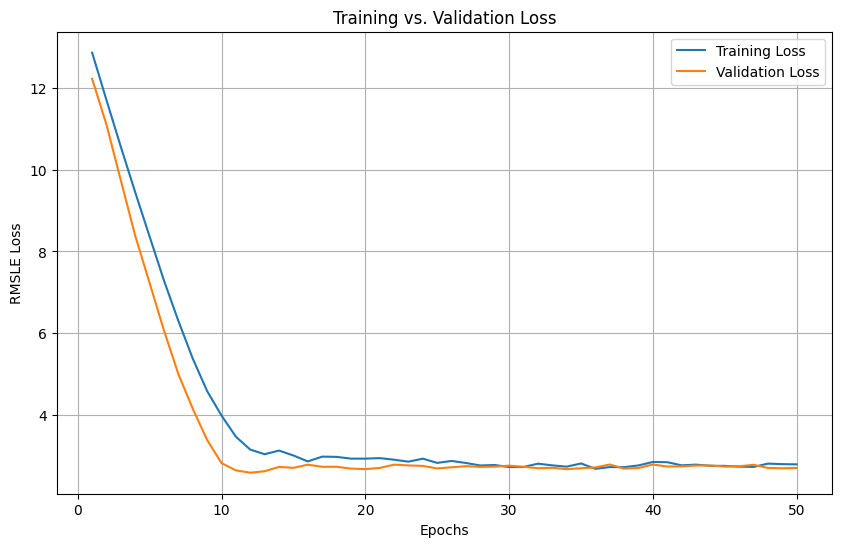

In [ ]:
model, house_predicted_prices = main()